<center>
    <h3>University of Toronto</h3>
    <h3>Department of Mechanical and Industrial Engineering</h3>
    <h3>MIE368 Analytics in Action </h3>
    <h3>(Fall 2020)</h3>
    <hr>
    <h1>Lab 1: Linear and Logistic Regression</h1>
    <h3>September 23, 2020</h3>
</center>


 # Introduction

Linear and logistic regression are two of the most widely used methods in analytics. They are used to model the relationship between a _target_ variable (i.e., dependent variable and one or more _features_ (i.e., independent variables). The application of these methods typically falls into one of two categories based on the end goal:

 1. __Prediction:__ estimate the target based on given features. The goal is to obtain a model that performs well on out-of-sample data (i.e., data it hasn't seen before).

 2. __Information extraction:__ reveal how the target is associated with the feature variables. Care is needed with respect to model assumptions when seeking to extract information.

__By the end of this lab you will be able to:__
> i) Apply linear regression to predict a continuous target.  
> ii) Apply logistic regression to predict a binary target.  
> iii) Apply feature selection and regularization to construct better models.  
> iv) Evaluate model fitness using $R^2$, mean accuracy, precision-recall, confusion matrices, and ROC curves.









# Application

In this lab, we will use data from the National Basketball League (NBA). We have two goals: (1) to understand and predict the relationship between stats and total number of wins, and (2) to understand and predict the relationship between stats and whether a team will make the playoffs. 
Our data includes team data from all NBA seasons between 1980 and 2016 except for the two lockout seasons (1999 and 2012). For a brief introduction to basketball, please watch the first 95 seconds of the following video:

<a href="https://www.youtube.com/watch?v=wYjp2zoqQrs
" target=""><img src="http://img.youtube.com/vi/wYjp2zoqQrs/0.jpg" 
alt="" width="240" height="180" border="10" /></a>

## Imports and Data

Lets start by importing the packages and data involved in this lab. 

In [ ]:
# Import the packages for this lab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import linear regression models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

# Import logistic regression models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Import confusion matrix function from sklearn
from sklearn.metrics import confusion_matrix

# Load all the data required for this lab
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1qCI6BGZpgenI0lLcBuJHTEst5PTIqXov')
df.head()  # Visualize small portion of the data

,SeasonEnd,Team,W,PTS,oppPTS,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,Conference,Playoffs
0,2014,Philadelphia 76ers,19,8155,9012,3108,7150,2531,5303,577,1847,1362,1918,949,2556,1791,765,330,1384,0,0
1,2004,Detroit Pistons,54,7388,6909,2747,6314,2414,5346,333,968,1561,2074,1014,2492,1702,659,570,1241,0,1
2,2004,San Antonio Spurs,57,7501,6909,2842,6434,2434,5294,408,1140,1409,2069,1029,2669,1676,661,537,1203,1,1
3,2004,Indiana Pacers,61,7493,7021,2753,6322,2304,5041,449,1281,1538,2014,965,2452,1774,726,411,1182,0,1
4,1997,Cleveland Cavaliers,42,7173,7022,2704,5972,2221,4688,483,1284,1282,1773,909,2159,1714,655,315,1188,0,0



The columns in the dataset should be as follows (21 columns total):

* **SeasonEnd**: season of play
* **Team**: team name (categorical)
* **W**: wins
* **PTS**: points scored over the season
* **oppPTS**: points scored on the team over the season
* **FG**: field goals made
* **FGA**: field goals attempted
* **2P**: 2-point field goals made
* **2PA**: 2-point field goals attempted
* **3P**: 3-point field goals made
* **3PA**: 3-point field goals attempted
* **FT**: Free throws made
* **FTA**: Free throws attempted
* **ORB**: Offensive rebounds made
* **DRB**: Defensive rebounds made
* **AST**: Assists made
* **STL**: Steals made
* **BLK**: Blocks made
* **TOV**: Turnovers made
* **Conference**: NBA conference that team plays is (0 = eastern, 1 = western)
* **Playoffs**: Whether or not team made playoffs (0 = missed, 1 = made)

Before we do anything, we should always try some exploratory data analysis to better understand what we are dealing with. Answer the questions below.

### Exercise

1. Is there any missing data?
2. Which team won the most games in a season?
3. Which team was the best defensive team (based on points scored against the team)?
4. Aside from playoffs, which feature is the most correlated with wins?

In [ ]:
# Question 1

# Write your code here.

# -------------------

print(f'There are {df.isnull().sum().sum()} missing data points')

# -------------------

There are 0 missing data points


In [ ]:
# Question 2

# Write your code here.

# -------------------

df.loc[df.W.idxmax()].Team

# -------------------

'Golden State Warriors'

In [ ]:
# Question 3

# Write your code here.

# -------------------

df.loc[df.oppPTS.idxmin()].Team

# -------------------


'Detroit Pistons'

In [ ]:
# Question 4

# Write your code here.

# -------------------

df.corr().W.drop(['W', 'Playoffs']).abs().idxmax()

# -------------------

'DRB'

## Feature engineering

In this section, we're going to use our findings in the previous exercise to make a new feature out of the existing data using a process called feature engineering. Consider that (in addition to being great overall team) the Golden State Warriors (2016) and Detroit Pistons (2004) are widely regarded as the best offensive and defensive team of our time, respectively. If you look at the full correlation matrix it seems like PTS and oppPTS are correlated with winning, but not as much as DRB. This should seem surprising as you would expect that the points scored and allowed should be the best indicator of whether a team wins a game. 

By applying some domain knowledge to this problem, however, we might reason that it is not the individual two features that affect how often you win but rather the combination of those features. In the code below, we create a new feature called "diffPTS" (to represent difference in points scored by a team and points scored against a team), and then we check how it correlates with wins.


In [ ]:
# Make new column in df
df['dffPTS'] = df.PTS - df.oppPTS  # new column data
dffPTS_corr = df[['dffPTS', 'W']].corr().iloc[0,1]  # get correlation with wins

# Get highest correlation coefficient from original data
highest_orig_corr = df.corr().W.drop(['W', 'Playoffs', 'dffPTS']).abs().max()

print(f'Using only the original features the highest correlation with wins was {highest_orig_corr:.3f},\n \
but our new feature had a much higher correlation with wins of {dffPTS_corr:.3f}')

Using only the original features the highest correlation with wins was 0.411,
 but our new feature had a much higher correlation with wins of 0.971


By engineering this new feature dffPTS we have a feature that correlates with wins more than any of the original features! As a very brief aside (will not be tested), the `:.3f` in the print statment is called a format specifier, and the logic is explained [here.](https://www.python.org/dev/peps/pep-0498/#format-specifiers)

# Linear Regression

Linear regression can be used when the target (i.e., what you're trying to predict) is a continuous variable that can take any values from minus infinity to positive infinity. Let $y$ represent the target and $x_1,x_2,\dots,x_K$ represent $K$ features (i.e., what you're using to predict the target). 

We use linear regression to find the best coefficients $\beta_0,\beta_1,\dots,\beta_K$, such that our predictions,

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_Kx_K,$

are as close as possible to the true target values, $\hat{y}$. We define the error (i.e., residual) for a given observation to be $(\hat{y} -y)$. Then we choose our regression coefficients to minimize the mean squared error (MSE) between the true target values and the predicted target values across all data points. For example, suppose we observe $n$ data points of the form $(y_i,x_{i1},x_{i2},\dots,x_{iK}), \;i=1,\dots,n$, then we would solve this optimization problem

$$
\begin{aligned}
\min_{\beta_0,\beta_1,\dots,\beta_K} \quad  & \frac{1}{n}\sum_{i=1}^n \left( \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \dots + \beta_Kx_{iK} - y_i \right)^2.     \quad\quad\quad (1)
\end{aligned}
$$

We denote the coefficients that minimize (1) by $\hat{\beta}_0,\hat{\beta}_1,\dots,\hat{\beta}_K$. 

## Coding up the model

In this course, we will mostly use the `scikit-learn` package to build predictive models. In `scikit-learn`, every model is defined as a class object that contains (amongst others), several standard methods:

* **fit()**: Takes training features and target as input and uses that to fit the model (i.e., find the best parameters for a model).
* **predict()**: Takes testing features as input and uses that to predict target values (i.e., use the model).
* **score()**: Takes testing features and target as input and uses that to measure the error (i.e., evaluate model performance).


We will now build a linear regression model to predict the total number of wins using all of the numerical features. When building any model, we make sure that we split the data into reasonable training and testing sets. We then use  [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) and fit our model on the training data and predict on the target data.

In [ ]:
# Split the data into training and testing sets
df_train = df[df.SeasonEnd<2012]
df_test = df[df.SeasonEnd>=2012]

# Define features to remove from the feature data (i.e., X)
drop_for_X = ['W','Team','SeasonEnd','Playoffs']

# Partition the training data into features and target
X_train = df_train.drop(columns=drop_for_X)
y_train = df_train.W

# Fit the model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Partition the testing data into features and target
X_test = df_test.drop(columns=drop_for_X)
y_test = df_test.W

# Predict the number of wins
y_test_predictions = linreg.predict(X_test)

In the codeblock above, we used the `predict()` method to predict $y$ for each data point (i.e., row) in `X_test`. To determine how _good_ those predictions were you should use the score function, as follows:

In [ ]:
train_score = linreg.score(X_train, y_train)
test_score = linreg.score(X_test, y_test)

print(f'The train score is {train_score:.3f} and the test score is {test_score:.3f}')

The train score is 0.944 and the test score is 0.888


The "score" for linear regression is the _coefficient of determination_ (i.e., $R^2$). In the space above, we calculated the score of the training and testing data, and we found that the model performed better on the training data ($R^2$=0.944) than it did on the testing data ($R^2=0.888). In general the model will perform better on the data it was trained on than data it is seeing for the first time (i.e., testing set). Although most (if not all) models in `scikit-learn` have a score method, the score that `score` evaluates depends on the model. Please keep this in mind when you write a report. 

In a `LinearRegression` model, the `coef_` attribute returns the values for $\beta$ and the `intercept_` attribute stores the value fo $\beta_0$.

In [ ]:
betas = pd.Series(linreg.coef_, index=X_train.columns)
betas = betas.append(pd.Series({"Intercept": linreg.intercept_}))
print(betas)

PTS          -1.032659e+10
oppPTS       -4.945743e+09
FG            3.136950e+10
FGA           1.995394e+10
2P           -8.248390e+08
2PA          -1.995394e+10
3P            1.444749e+10
3PA          -1.995394e+10
FT            1.527233e+10
FTA          -1.105242e-03
ORB           1.955840e-03
DRB           2.634602e-03
AST           1.160074e-03
STL           1.172673e-03
BLK           3.770994e-03
TOV          -2.041234e-03
Conference    1.902110e-01
dffPTS       -4.945743e+09
Intercept     3.897555e+01
dtype: float64


You should observe that some of the beta coefficients (e.g., for `oppPTS` and `dffPTS`) are identical, which is the sign of a problem. The problem is that many of the features are highly correlated with each other, and we are therefore violating the assumption of no multi-collinearity!

### Exercise
1. In the space below, plot the correlation matrix. Which two features are the most correlated?

,SeasonEnd,W,PTS,oppPTS,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,Conference,Playoffs,dffPTS
SeasonEnd,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PTS,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oppPTS,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FG,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FGA,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2P,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.994511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.994511,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


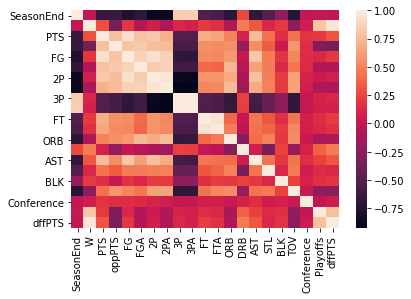

In [ ]:
# Write your code here.

# -------------------

sns.heatmap(df_train.corr())
df_train.corr()[df_train.corr().abs() > 0.99]

# -------------------

___
**Question 1 answer:** a quick spot-check shows that 3P and 3PA have a correlation of 0.99
___

## Correlated features
Below we define a function and describe it with a [_doc string_](https://www.datacamp.com/community/tutorials/docstrings-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034352&utm_targetid=aud-392016246653:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9061009&gclid=Cj0KCQjwy8f6BRC7ARIsAPIXOjhfMN9Oj6QCqNfMMDgZYqFFwp7yv6P9V_agl4PtR3O6o95GidfErGYaAsSCEALw_wcB) (i.e., the string at the begining of the function). A doc string should be present at the begining of most functions contained in reputable python packages.  We'll use this function to go through every feature and count the number of times this feature is correlated or anti-correlated with another feature by more than `threshold`. We set the default value of `threshold` to 0.7.


In [ ]:
# Define a function
def print_heavily_correlated_features(df, threshold=0.7):
  """
  For each feature in "df", this function counts the number of features that 
  have a correlation coefficient with that is higher than "threshold".

  Parameters
  ----------
    df: pandas DataFrame type 
        Contains the features for several data points
    threshold: float type 
        he threshold for which "heavily correlated" is defined.
  """

  corr = df.corr().abs()  # calculate the correlation matrix
  corr = corr[corr > threshold]  # a mask of features that are heavily correlated

  # Print out the "heavily correlated" counts
  print(corr.count().sort_values(ascending=False) - 1)  

# Execute the function
print_heavily_correlated_features(df_train)  

2P            9
2PA           9
SeasonEnd     7
FG            7
PTS           6
FGA           6
oppPTS        5
3P            4
3PA           4
AST           3
ORB           3
W             2
dffPTS        2
Playoffs      2
FTA           1
TOV           1
FT            1
DRB           0
STL           0
BLK           0
Conference    0
dtype: int64


### Exercise
1. Why did we run the above function on df_train rather than df?

2. In the codeblock below, we created a new DataFrame called `df_reduced`. Use it to fit a better regression model by following these steps: 
i)  From `df_reduced` remove the 5 features most heavily susceptible to multi-collinearity (i.e., 2P, 2PA, FG, PTS, FGPA).  
ii) Then, fit a new linear regression model `linreg_reduced` to this data set using the same train-test split.  
iii) Report the score and the beta coefficients.
___
**Question 1 answer:**
We should be doing all analysis with respect to model fitting on our training set. The test set is used only to evaluate model quality.
___


In [ ]:
# We have made a copy of the data frame
df_reduced = df.copy()

# REMEMBER: remove drop the features listed in drop_for_X from X_train and X_test

# Write your code here.

# -------------------

# Step i starts here
# Remove the correlated columns
columns_to_remove = [ '2P', '2PA', 'FG', 'PTS', 'FGA']
df_reduced = df_reduced.drop(columns=columns_to_remove)

# Step ii starts here
# Split the data into training and testing sets
df_train = df_reduced[df_reduced.SeasonEnd<2012]
df_test = df_reduced[df_reduced.SeasonEnd>=2012]

# Partition the training data into features and target
X_train = df_train.drop(columns=drop_for_X)
y_train = df_train.W

# Fit the model
linreg_reduced = LinearRegression()
linreg_reduced.fit(X_train, y_train)

# Partition the testing data into features and target
X_test = df_test.drop(columns=drop_for_X)
y_test = df_test.W

# Step iii starts here
# calculate the score
train_score = linreg_reduced.score(X_train, y_train)
test_score = linreg_reduced.score(X_test, y_test)
print(f'The train score is {train_score:.3f} and the test score is {test_score:.3f}')

# calculate betas
betas = pd.Series(linreg_reduced.coef_, index=X_train.columns)
betas = betas.append(pd.Series({"Intercept": linreg_reduced.intercept_}))
print(betas)

# -------------------


The train score is 0.944 and the test score is 0.932
oppPTS        -0.000136
3P            -0.007007
3PA            0.002766
FT             0.000195
FTA           -0.000227
ORB           -0.000462
DRB            0.001097
AST            0.001251
STL           -0.000716
BLK            0.003887
TOV           -0.000670
Conference     0.203804
dffPTS         0.032004
Intercept     37.067376
dtype: float64


You should notice that your model now gives a much higher score on the test set! Furthermore, the test score is more or less the same as the train score.

## Overfitting

In the first model that used all of the features (i.e., `linreg`), the train score was much higher than the test score. This means that the model was _overfitting_ to the training set. Overfitting occurs when the model identifies relationships that are unique to the training set and do not generalize to unseen (testing) data. Note that in the model with fewer features (i.e., the reduced model) actually performed much better on the out-of-sample data because it did not overfit. 

Multi-collinearity can cause overfitting, but there are other causes that we won't cover in this lab including:

1. Small dataset
2. Complex model 
3. Hidden biases in the data (e.g., multi-collinearity)

Another important observation is that the $\beta$ values make a lot more sense now in terms of how they would affect the number of wins of a given team.



### Exercise
1. How many more three point shots does a team need to score in a given season in order to win 1 additional game?

2. According to your model, does having more offensive rebounds help or hurt a team's chances of winning games? Does this make sense? Why or why not?

___
**Question 1 answer**

$$
\begin{align}
1 &= \beta_{3P}x + \beta_{3PA}x + \beta_{dffPTS} (3x)\\
x &= 10.90
\end{align}
$$
___
**Question 2 answer**:

Offensive rebounds seem to hurt the chances of winning. This suggests that the model is still somewhat failing to characterize the effect of the features.
___

# Regularization

Previously, we saw that the model was overfitting because it had too many features. To reduce overfitting, we used our domain knowledge to remove features from the model using a process called _manual feature selection_. If we have a poor understanding of the problem domain and/or we suspect our model is overfitting then doing manual feature selection is difficult. 

A more automated way to reduce overfitting that requires no domain knowledge is _regularization_. This technique is especially useful in applications with a _relatively large_ number of features ($K$) compared to the number of samples ($N$) in the training dataset. A __very rough__ rule of thumb is that you should have no more than $\sqrt N$ features in your model (i.e., $K\le\sqrt N$). Regularization is a very general operation that can be applied to most models. In this section, we'll explain regularization in the context of linear regression.

In regularized linear regression, we add the term $\frac{1}{C}\sum_{k=1}^K |\beta_k|^p$ to the objective of Equation (1), where $p$ is a number that denotes the type of regularization (e.g., L1, L2) and $\frac{1}{C}$ is a parameter learned by the model (or occasionally selected by the user). The parameter $\frac{1}{C}$ controls the _strength of regularization_. Intuitively, you can think of regularization as a process that penalizes non-zero regression coefficients (i.e., $\beta > 0$), but keep in mind that different types of regularization produce different results. There are two common types of regularization:

 1. __L1-regularization ($p=1$):__ Also called _LASSO_ regression, is frequently used for feature selection because it implicitly produces a sparse solution, i.e., only a small portion of the regression coefficients will be non-zero. Using L1-regularization, we can rewrite (1) as             
    \begin{aligned} 
        \min_{\beta_0,\beta_1,\dots,\beta_K} \quad  & \frac{1}{n}\sum_{i=1}^n \left( \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \dots + \beta_Kx_{iK} - y_i \right)^2 + \frac{1}{C} \sum_{k=1}^K |\beta_k|.
    \end{aligned}
               
 2.  __L2-regularization ($p=2$):__ Also called _ridge_ regression, is frequently used to produce a model that tries to use all of the available features. Using L2-regularization, we can rewrite (1) as
        \begin{aligned}
            \min_{\beta_0,\beta_1,\dots,\beta_K} \quad  & \frac{1}{n}\sum_{i=1}^n \left( \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \dots + \beta_Kx_{iK} - y_i \right)^2 + \frac{1}{C} \sum_{k=1}^K |\beta_k|^2.
        \end{aligned}
        

Both methods reduce the sum of coefficients and prevent overfitting, however, in general each methods has different use cases. Also, note that L2-regularization is more computationally efficient than L1-regularization.



## Cross-validation
_Cross-validation_ is a process for selecting model hyper-parameters (e.g., $C$) that generalize to out-of-sample data. Cross-validation is performed in $m$ rounds. In each round the training set is split into two subsets (1) a subset that the model is trained on, and (2) a subset that the model is evaluated on. After the rounds are complete, an aggregate measure of performance (e.g., average score) is used to measure model performance. 

We can use cross validation to search for the best parameter out of a list. For example, we could look for the best parameter $C$ for a regression model out of the list [0.1, 1, 10, 100]. Cross-validation would perform $m$ rounds ($m=4$ in this example) for each element in that list, and give us the best performing model (i.e., the best available $C$). 

Let's try building a new linear regression model with regularization. We'll pretend that we know nothing about basketball. In this case we use the [`LassoCV` model from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) to build an L1-regularized linear regression model. The `LassoCV` model automatically applies cross-validation to find the best value for $C$.

In [ ]:
# Let's go back to the original data set without the removed features
# Split the data into training and testing sets
df_train = df[df_reduced.SeasonEnd<2012]
df_test = df[df.SeasonEnd>=2012]

# Partition the training data into features and target
X_train = df_train.drop(columns=['W','Team','SeasonEnd'])
y_train = df_train.W

# Fit the model
lasso = LassoCV()
lasso.fit(X_train, y_train)

# Partition the testing data into features and target
X_test = df_test.drop(columns=['W','Team','SeasonEnd'])
y_test = df_test.W

# calculate the score
train_score = lasso.score(X_train, y_train)
test_score = lasso.score(X_test, y_test)
print(f'The train score is {train_score:.3} and the test score is {test_score:.3}')

# calculate betas
betas = pd.Series(lasso.coef_, index=X_train.columns)
betas = betas.append(pd.Series({"Intercept": lasso.intercept_}))
print(betas)

The train score is 0.942 and the test score is 0.949
PTS            0.000000
oppPTS        -0.000000
FG             0.000000
FGA           -0.000000
2P            -0.000000
2PA           -0.000000
3P             0.000000
3PA            0.000000
FT            -0.000000
FTA           -0.000000
ORB           -0.000000
DRB            0.000000
AST            0.000000
STL           -0.000000
BLK            0.000000
TOV           -0.000000
Conference     0.000000
Playoffs       0.000000
dffPTS         0.032282
Intercept     41.000000
dtype: float64


You should observe that the LASSO model performs better than our manually reduced model! Remember that the model automatically performed cross-validation to get the best regularization strength. Also notice that the beta values are approximately zero for nearly every feature except for dffPTS. 

### Exercise
1. Use the attribute `alpha_` to find the regularization strength (i.e., $\frac{1}{C}$) for the model `lasso`. Keep in mind that the attribute `alpha_` returns $\alpha = \frac{1}{C}$.

2. Would you prefer this model (`lasso`) or the one with manual feature selection (`linreg_reduced`) to better understand what it takes to win?

3. Try building a LASSO model with the reduced data set (`df_reduced`). Do you expect it to differ from the above LASSO model? How does it perform?

4. In the space below, fit a ridge regression model on the original dataset (`df`) using [`RidgeCV` from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV), and call that model `ridge`. Compare the test score and the betas with the `lasso` model. How do the models differ with respect to score and betas? Which model would you use to understand the effects of features on winning?


In [ ]:
# Question 1

# Write your code here.

# -------------------

print(f'The regularization strength is 1/C = {lasso.alpha_:.3f}')

# -------------------


The regularization strength is 1/C = 43.726


___
**Question 2 answer:**

I would use the LASSO model because everything boils down to a single very interpretable feature. This is great because you don't need to worry about how each feature depends on each other (e.g., how scoring a 3 point shot will change other features).
___
**Question 3 answer:**

It builds an identical model. This is expected because the features that we removed from `df` to make `df_reduced` had zero weight in the `lasso` model. 
___



In [ ]:
# Question 4 code

# Write your code here.

# -------------------

# Let's go back to the original data set without the removed features
# Split the data into training and testing sets
df_train = df[df.SeasonEnd<2012]
df_test = df[df.SeasonEnd>=2012]

# Partition the training data into features and target
X_train = df_train.drop(columns=drop_for_X)
y_train = df_train.W

# Fit the model
ridge = RidgeCV()
ridge.fit(X_train, y_train)

# Partition the testing data into features and target
X_test = df_test.drop(columns=drop_for_X)
y_test = df_test.W

# calculate the score
train_score = ridge.score(X_train, y_train)
test_score = ridge.score(X_test, y_test)
print(f'The train score is {train_score:.3} and the test score is {test_score:.3}')

# calculate betas
betas = pd.Series(ridge.coef_, index=X_train.columns)
betas = betas.append(pd.Series({"Intercept": ridge.intercept_}))
print(betas)

# -------------------

The train score is 0.944 and the test score is 0.89
PTS            0.008856
oppPTS        -0.011170
FG             0.003202
FGA           -0.000576
2P             0.003958
2PA           -0.001742
3P            -0.000756
3PA            0.001166
FT             0.003209
FTA           -0.001101
ORB            0.001959
DRB            0.002638
AST            0.001155
STL            0.001179
BLK            0.003776
TOV           -0.002044
Conference     0.180656
dffPTS         0.020026
Intercept     38.852343
dtype: float64


___
**Question 4 answer:**

The `ridge` model is actually quite informative even though it performs worse than `lasso` on the test set. Notice that the signs on all of the features make intuitive sense. oppPTS and TOV should be negative as those things are generally bad for a team. FGA, 2PA, FTA are all negative, but FG, 2P, FT are positive, meaning that shooting more isn't necessarily good but scoring more is. Unfortunately, this intuition doesn't extend to the 3P feature, which is still negative.

Overall, the `lasso` model is still the most interpretable model. It simply says, "score more points than your opponent, and you'll win more games". In contrast, the `ridge` model just us some more information about what specific actions a team could take to win more games.
___


# Logistic Regression

Logistic regression can be used when the target is a categorical variable that  takes values of 0 and 1. Recall that in linear regression, $y$ is modeled as a linear function of $\mathbf{x}$; in logistic regression, we model the _logit_ or _log-odds ratio_ as a linear function of $\mathbf{x}$. That is,

$$
\begin{aligned}
    \mathrm{logit}(y) = \log\left(\frac{y}{1-y}\right) = \beta_0 + \beta_1 x_1 + \dots + \beta_K x_K
\end{aligned}
$$

We can rewrite the logit equation to obtain the probability,

$$
\begin{aligned}
y = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_K x_K)}}
\end{aligned}
$$

In order to turn the logit into a prediction, we apply a threshold rule $T(y)$. For example, a threshold rule of $0.5$ corresponds to
$$ T(y) = 
\begin{cases}
     1,& \text{ if } y \geq 0.5, \\
     0,& \text{ if } y \leq 0.5.
\end{cases}$$




## Evaluating model performance

The standard way to score (i.e., evaluate performance) a logistic regression is via mean accuracy. This is equal to the proportion of data points $i = 1, 2, \dots, n$ for which $T(y_i) = \hat{y}_i$. We calculate it as 
$1 - \frac{\sum_{i=1}^N |T(y_i) - \hat{y}_i| }{N}$. We can think of this scoring metric for logistic regression as something that is analogous to the $R^2$ metric for linear regression. 

For a binary classification problem, although the accuracy of a model is a great measure of its performance, accuracy fails to reveal the type of errors that the model makes. There are two main types of errors: (1) false positives (FP), where a value of $1$ is predicted (i.e., $y = 1$) when the true value is $0$ (i.e., $\hat{y} = 0$); and (2) false negatives (FN), where a value of $0$ is predicted (i.e., $y = 0$) when the true value is $1$ (i.e., $\hat{y} = 1$). A correctly classified point is a true positive (TP) or true negative (TN) when a value of $1$ or $0$ is correctly predicted, respectively. There are several common summary statistics that summarize the frequency of different error types that are summarized in the following table.

| Statistic                             | Calculation    | Definition |
|:--------------------------------------|:--------------:|:-----------|
| Recall/Sensitivity/True Positive Rate | TP / (TP + FN) | the proportion of $y_i = 1$ that were correctly labelled |
| Fall-out/False Positive Rate          | FP / (FP + TN) | the proportion of $y_i = 0$ that were incorrectly labelled |
| Precision/Positive Predictive Value   | TP / (TP + FP) | the proportion of $T(\hat{y}_i) = 1$ that match the data |
| False Omission Rate                   | FN / (FN + TN) | the proportion of $T(\hat{y}_i) = 0$ that don't match the data |

In general, true positive rate (TPR) and false positive rate (FPR) are the most common of the ratios presented above. TPR is a measure of how often we correctly identify when the target is true (i.e., $y = 1$ and $\hat{y} = 1$), and FPR is a measure of how often we incorrectly identify when the target is true (i.e., $y = 1$ and $\hat{y}=0$). There are many other metrics that quantify model error, and the best metric to use depends on the application of the model. We can summarize all of this information inside a confusion matrix.

![alt text](https://miro.medium.com/max/1194/0*wKaznIJzZF54b87B.jpg)


## Coding the model

Remember that linear regression predicts continuous target values, and logistic regression predicts target binary values (i.e., categorical). While we used linear regression to predict the total number of games that a team is expected to win in a season, we will now use logistic regression to predict whether a team will make the playoffs or not.



### Exercise
1. In the space below, fit a [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model called `logreg` to predict the target (from the column "Playoffs" in `df`) using the same features that we used in the linear regression model above. Don't forget to drop the column headings ['W','Team','SeasonEnd', 'Playoffs'], which are stored in the variable `drop_for_X`, from your features (`X_train` and `X_test`).

In [ ]:
# Split the data into training and testing sets
df_train = df[df.SeasonEnd<2012]
df_test = df[df.SeasonEnd>=2012]

# Write your code here.

# -------------------

# Partition the training data into features and target
X_train = df_train.drop(columns=drop_for_X)
y_train = df_train.Playoffs

# Fit the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Partition the testing data into features and target
X_test = df_test.drop(columns=drop_for_X)
y_test = df_test.Playoffs

# Predict the number of wins
y_pred = logreg.predict(X_test)

# -------------------

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Addressing a warning message
You should see a message about a `ConvergenceWarning` that explains that the solver (i.e., the optimizer that "finds" the coefficients for the model) failed to converge before fitting the iteration limit. This limit is set by the `max_iter` parameter, and by default it is limited to 100 iteration.



### Exercise
1. Make a new model called `logreg_max_iter_5000` by training the model from the code block above for a maximum of 5000 iterations. 

2. Use the `score` method for logistic regression to evaluate the mean accuracy of `logreg` and `logreg_max_iter_5000`. What model performed best? 



In [ ]:
### Question 1

# -------------------

# Fit the model
logreg_max_iter_5000 = LogisticRegression(max_iter=5000)
logreg_max_iter_5000.fit(X_train, y_train)

# -------------------

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#### Question 2

# -------------------

# Calculate score of model trained with default parameters
train_score = logreg.score(X_train, y_train)
test_score = logreg.score(X_test, y_test)

# Calculate score of model trained with max iterations 5000
train_score_max_iter_5000 = logreg_max_iter_5000.score(X_train, y_train)
test_score_max_iter_5000 = logreg_max_iter_5000.score(X_test, y_test)

# Print the results
print(f'With default parameters: \n\
\t Train score {train_score:.3}\n\
\t Test score {test_score:.3}')
print(f'With max_iters = 5000: \n\
\t Train score {train_score_max_iter_5000:.3}\n\
\t Test score {test_score_max_iter_5000:.3}')

# -------------------

With default parameters: 
	 Train score 0.909
	 Test score 0.808
With max_iters = 5000: 
	 Train score 0.915
	 Test score 0.817


By addressing that warning messages we managed to get ~1\% improvement in performance! If you reviewed the  `LogisticRegression` documentation, you may have noticed that the the `fit` method uses L2-regularization by default. Also recall (from the linear regression section) that the features of this model are highly correlated with each other, which is problematic. 

Let's try using L1-regularization by setting the `penalty` parameter of `LogisticRegression` to 'l1'. We also need to set the solver to 'saga' because the default solver of `LogisticRegression` does not work with L1 regularization:

In [ ]:
# Fit the model
logregl1 = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
logregl1.fit(X_train, y_train)

# Partition the testing data into features and target
X_test = df_test.drop(columns=['W','Team','SeasonEnd', 'Playoffs'])
y_test = df_test.Playoffs

# calculate the score
train_score = logregl1.score(X_train, y_train)
test_score = logregl1.score(X_test, y_test)
print(f'The train score is {train_score:.3} and the test score is {test_score:.3}')


The train score is 0.91 and the test score is 0.808


## Using cross validation to select regularizer
You should see that the L2 regularized model performed better than the L1 regularized model. However, before we make any conclusion about which regularizer is better suited for this problem, it is important to recognize that we did not perform cross-validation to optimize for the strength of the regularizer.



### Exercise
1. Use the [`LogisticRegressionCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to fit a model that uses cross-validation and choose the best regularizer strength. Call your model `logregcv`.

2. What is the optimal regularization strength? Check the documentation to find what variable it is listed under.

In [ ]:
# Question 1
# Write your code here.

# -------------------

# Fit the model
logregcv = LogisticRegressionCV(penalty='l1', solver='saga', max_iter=5000)
logregcv.fit(X_train, y_train)

# Partition the testing data into features and target
X_test = df_test.drop(columns=['W','Team','SeasonEnd', 'Playoffs'])
y_test = df_test.Playoffs

# calculate the score
train_score = logregcv.score(X_train, y_train)
test_score = logregcv.score(X_test, y_test)
print(f'The train score is {train_score:.3} and the test score is {test_score:.3}')

# -------------------

The train score is 0.903 and the test score is 0.883


In [ ]:
# Question 2

# -------------------

print(f'The strength of the regularier is {1/logregcv.C_[0]}')

# -------------------

The strength of the regularier is 10000.0


## Interpreting model parameters

In this section, we'll use the `logregcv` model to make some inferences about making the NBA playoffs. Once again, we can view the coefficients and the intercept of the fitted model using the `coef_` and `intercept_` attributes. However, you may notice that logistic regression has a slightly different format than linear regression! We have provided the code for it below.

In [ ]:
# Get beta coefficients
betas = pd.Series(logregcv.coef_[0], index=X_train.columns)
# Get intercept, and append it to coefficients
betas = betas.append(pd.Series({"Intercept": logregcv.intercept_[0]}))
# Print the all betas (including the intercept)
print(betas)

PTS           0.000003
oppPTS        0.000000
FG            0.000000
FGA           0.000000
2P            0.000000
2PA           0.000000
3P            0.000000
3PA           0.000000
FT            0.000000
FTA           0.000000
ORB           0.000000
DRB           0.000000
AST           0.000000
STL           0.000000
BLK           0.000000
TOV           0.000000
Conference    0.000000
dffPTS        0.007941
Intercept     0.000002
dtype: float64


### Exercise 
To answer the set of questions in this exercise you'll need to examine the coefficients of the `logregcv` model. You may find the [`predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict), [`predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba), and [`predict_log_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_log_proba) methods useful.


1. Suppose that the Toronto Raptors have the statistics stored in `raptors_2020`. What is the probability that the raptors make the playoffs?

2. The Toronto Raptors won the 2019 NBA Championships off of strong defence. Calculate the log-odds and the odds ratio of a team that gets 50 more steals and 100 more blocks. What does the odds ratio say about the likelihood of making the playoffs?


In [ ]:
### Question 1

raptors_2020 = pd.DataFrame([{'PTS': 10105, 'oppPTS': 10054, 'FG': 3951, 
                           'FGA':7999, '2P': 3927, '2PA': 7873, '3P': 24,
                           "3PA": 126, 'FT': 2179, 'FTA': 2696, 'ORB':1214,
                           'DRB': 2524, 'AST': 2336, 'STL': 789, 'BLK': 352,
                           'TOV': 1496, 'Conference': 0, 'dffPTS': 51}])

# Write your code here.

# -------------------

raps_playoffs_chances = logregcv.predict_proba(raptors_2020)
print(f'The raptors have a probability of {raps_playoffs_chances[0, 1]:.3} of making the playoffs.')

# -------------------

The raptors have a probability of 0.607 of making the playoffs.


In [ ]:
### Question 2

# Write your code here.

# -------------------

logodds = 50 * betas['STL'] + 100 * betas['BLK']
odds = np.exp(logodds)
print(f'The log odds ratio is {logodds}, the odds ratio is {odds}')
# -------------------

The log odds ratio is 0.0, the odds ratio is 1.0


___
**Question 2 Answer:**

This implies the chance of making the playoffs is unchanged (no better and no worse). 

Anyone with some domain knowledge likely finds this result surprising. We observe it because the model has learned that dffPTS is a good feature to predict playoff chances, however, it has not learned what actions are good (e.g., 'STL', 'BLK') to increase dffPTS or playoff chances. A better model to use for this particular problem would be one that uses more features (e.g., `logreg`).
___


## Classification Error

So far, we have only evaluated the model performance based on accuracy, however, it is also good to know what type of errors the model is susceptible to. Scikit-learn provides an easy way to do this via the `confusion_matrix()` function.

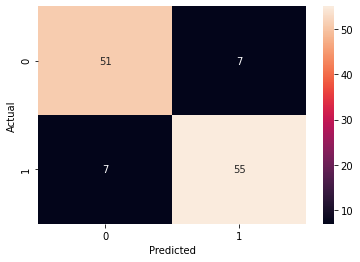

In [ ]:
# Make a prediction
y_pred = logregcv.predict(X_test)
# Make the confusion matrix
cfm = confusion_matrix(y_true=y_test, y_pred=y_pred)
# Plot the confusion matrix as a heat map
ax = sns.heatmap(cfm, annot=True)
# Change the axis lables
ax.set(xlabel='Predicted', ylabel='Actual');

### Exercise
Use the Confusion matrix above to answer the following questions.

1. What is the number of true positives? true negatives?
2. What is the biggest type of error that the model makes?
3. Calculate the recall and precision. 
4. Given these scores, if a team were to make the playoffs in reality, how likely do you think that the model would predict correctly? 
5. If the model predicts that a team will make the playoffs, how likely do you think that the model is correct?

In [ ]:
### Question 1

# Write your code here.

# -------------------

true_negatives = cfm[0,0]
true_positives = cfm[1,1]
print(f'There are {true_negatives} true negatives and {true_positives} true positives')

# -------------------

There are 51 true negatives and 55 true positives



___
**Question 2 answer:** False positives
___



In [ ]:
### Question 3

# Write your code here.

# -------------------

recall = cfm[1,1] / (cfm[1,0] + cfm[1,1])
precision = cfm[1, 1] / (cfm[0, 1] + cfm[1, 1])
print(f'The recall is {recall} and the precision is {precision}')

# -------------------

The recall is 0.8870967741935484 and the precision is 0.8870967741935484



___
**Question 4 answer:**

If a team were to make it (i.e., Actual = 1), then we predict it accurately nearly always. (Recall)

___


___
**Question 5 Answer:**

If a team were to make it (i.e., Actual = 1), then we predict it accurately nearly always. (Precision)

___


## Picking a prediction threshold
Recall that a logistic regression model outputs the probability of whether the the target is 1 or 0. We then apply a threshold rule to turn that probability into a prediction. The default threshold in scikit-learn is 0.5, but it is a good idea to examine the raw probabilities to see if a better threshold exists.

The tool that is most used to help choose a threshold is a receiver operating characteristic (ROC) curve. The ROC curve is a plot of true positive rate (TPR) versus false positive rate (FPR) for different threshold values. It is used in a lot in applications where it is important to make sure that there are very few false positives (i.e., false alarms) or very few false negatives (i.e., missed detections).

In this section you will plot ROC curves for the three logistic regression models that we built (i.e., `logreg`, `logregl1`, `logregcv`). The [`roc_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) function in `sklearn` makes it easy to generate the data for an ROC curve plot. As input, this function takes the ground truth target label and the model's estimated probability of "1", which is generated by the [`predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) method. As output, `roc_curve()` returns the FPR, TPR, and the threshold to achieve those statistics.


### Exercise

1. Plot FPR and TPR using [`sns.lineplot()`](https://seaborn.pydata.org/generated/seaborn.lineplot.html) to generate an ROC curve for each of the three models (i.e., `logreg`, `logregl1`, `logregcv`). We have provided some of the code to format the resulting plot.

2. What does the straight line from (0,0) to (1,1) represent?

3. According to the `roc_curve()` function, what is the highest threshold value at which you should get a TPR=1 for your L1-cross-validated model?

4. Is there any scenario where the cross-validated model is worse than any of the other models?


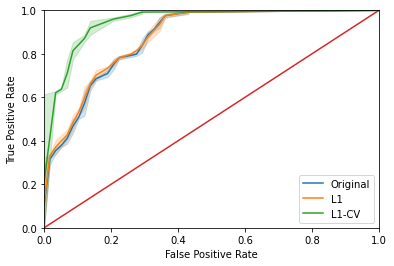

In [ ]:
from sklearn.metrics import roc_curve

# Write your code here.

# -------------------

# L2 model
ylogreg = logreg.predict_proba(X_test).T[1]  # Predictions without threshold 
fprlogreg, tprlogreg, threshlogreg = roc_curve(y_test, ylogreg)  

# L1 model
ylogregl1 = logregl1.predict_proba(X_test).T[1]
fprlogregl1, tprlogregl1, threshlogregl1 = roc_curve(y_test, ylogregl1)

# L1 model with CV
ylogregcv = logregcv.predict_proba(X_test).T[1]
fprlogregcv, tprlogregcv, threshlogregcv = roc_curve(y_test, ylogregcv)

# Plot the ROC of each model with approporiate lables for legend
sns.lineplot(fprlogreg, tprlogreg, label='Original')
sns.lineplot(fprlogregl1, tprlogregl1, label='L1')
sns.lineplot(fprlogregcv, tprlogregcv, label='L1-CV')

# -------------------

# Plot format
sns.lineplot([0, 1], [0, 1], linestyle='--')  # add red line
plt.xlim([0.0, 1.0])  # limit x-axis between 0 and 1
plt.ylim([0.0, 1.0])  # limit y-axis between 0 and 1
plt.xlabel('False Positive Rate')  # lable for x axis
plt.ylabel('True Positive Rate')  # lable for y axis
plt.legend(loc='lower right')  # print legend in lower right corner
plt.show()  

In [ ]:
threshlogregl1

array([1.99999999e+00, 9.99999991e-01, 9.99871187e-01, 9.99851937e-01,
       9.99816306e-01, 9.99778719e-01, 9.99222278e-01, 9.99008518e-01,
       9.98443082e-01, 9.98310013e-01, 9.94928179e-01, 9.94860173e-01,
       9.94131107e-01, 9.93300796e-01, 9.81291603e-01, 9.80163602e-01,
       9.78153043e-01, 9.76005163e-01, 9.66713898e-01, 9.58771002e-01,
       9.53306431e-01, 9.49773877e-01, 9.39164414e-01, 9.24068772e-01,
       9.22578115e-01, 8.87235640e-01, 8.79800360e-01, 8.47063399e-01,
       8.31381922e-01, 7.95228378e-01, 7.63353358e-01, 7.46495526e-01,
       7.10173352e-01, 6.52543498e-01, 5.35521503e-01, 5.22519041e-01,
       4.04966064e-01, 2.56262685e-01, 1.97142828e-01, 1.25453023e-05])

___
**Question 2 answer:**

If you were to randomly guess 1 or 0 without using any features

___

In [ ]:
# Question 3

# Write your code here.

# -------------------
first_1_in_TPR = np.argwhere(tprlogregcv==1)[0,0]  # Return first instance of 1
highest_TPR_1_threshold = threshlogregcv[first_1_in_TPR]
print(f'The highest threshold that achieves 100% TPR is {highest_TPR_1_threshold:.3}')
# -------------------

The highest threshold that achieves 100% TPR is 0.192


___
**Question 4 answer**:

No. In general, a curve is worse than another curve if it is closer to the red line.
___

# Reflection
 If we want to build a prediction model it is critical that we have access to its features at a reasonable time in real life. Unfortunately, in our case the models in this lab are not very useful because they use the features of a season (e.g., how many points a team scored) to predict outcomes for that same season (e.g., whether or not a team made playoffs) only after those outcomes are effectively known. A more impactful predictive model would use the features at the end of the season to predict if a team will make playoffs in the following season (e.g., use 2015 data to predict `'Playoffs'` in 2016). In this section you're going to code up that very model!

In the code block below, we do some (advanced) data processing to prepare the data you need to predict whether or not a team will qualify for playoffs next year. We use the column `'NextYearPlayoffs'` to denote whether or not a team will (`'NextYearPlayoffs'` = 1) or will not (`'NextYearPlayoffs'` = 0) make playoffs. The code block below generates this feature using [multi indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), but we don't expect you to understand multi-indexing at this stage in the course  (i.e., the code block immediately below will not come up in any capacity during Quiz 1).


In [ ]:
"""In this codeblock, we process the data for you using functions that you DO 
NOT need to be familiar with right now (you won't be tested on this type of 
data manipulation in Quiz 1). Please focus on the logic behind this code block
and understand why we modify the data the way we do."""

# Make a copy of the original DataFrame
X = df.copy()

# Change the index to Team and Season
X = X.set_index(['Team', 'SeasonEnd'])
# Keep SeasonEnd as one of the columns
X['SeasonEnd'] = X.index.get_level_values(1).values 

# Get y data (i.e., if they make playoffs next year)
y = pd.concat((df['Team'], 
               df['SeasonEnd']-1, 
               df['Playoffs'].rename('NextYearPlayoffs')
              ), 
              axis=1)
# Set the index to the same convention as X
y = y.set_index(['Team', 'SeasonEnd'])

# Get intersection of indicies between X and y
index_intersection = X.index.intersection(y.index)
X = X.loc[index_intersection]  # Season stats
y = y.loc[index_intersection]  # Whether or no team makes playoffs next year

### Exercise
1. Use the newly processed data (X and y) to predict whether or not a team will make playoffs in the following year based on their stats from the previous season.

2. Based on mean accuracy, you should see that this new model performs worse than the previous models. Why do you think that is?

3. In what way is the first set of models useful (i.e., predicting playoffs based on this season's data), and in which way is this new model useful (i.e., predicting playoffs based off last season's data)?

In [ ]:
# Question 1
# Write your code here.

# -------------------
# Split into training and testing
X_train = X[X.SeasonEnd<2012]
y_train = y.loc[X.SeasonEnd<2012].NextYearPlayoffs
X_test = X[X.SeasonEnd>2012]
y_test = y[X.SeasonEnd>2012].NextYearPlayoffs

# Fit the model
logregpred = LogisticRegressionCV(penalty='l1', solver='saga', max_iter=5000)
logregpred.fit(X_train, y_train)

# Partition the testing data into features and target
mdl_score = logregpred.score(X_test, y_test)

print(mdl_score)
# -------------------


0.6888888888888889


___
**Question 2 answer:**

This model performed worse because it uses features from a previous season, which don't directly affect a team's chances of making playoffs. There is no guarantee that a team can repeat those statistics in the following year. In contrast, the earlier models in this lab predicted whether or not a team made playoffs only when they knew __exactly__ how a team performed (i.e., had perfect information).
___
**Question 3 answer:**

The previous model is useful for identifying features that lead to new playing/practice strategies, which can inform coaching decisions. In contrast, the new model is useful for understanding how a team will do in the following season if they keep things the same (e.g., player roster) for next year, which can inform manger decisions (e.g., player trades).
___
